In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from optimizer import Adam


sigma_distribution = 180
theta0=90

sigma_res_noise = 0.005
sigma_S = 0.002

spatial_res = 5

gamma_pg=0.5

gradient_spectral_rad = .5

description='rho=' + str(gradient_spectral_rad) + '_5'

def encode(pos, res = None):
    if res is None: res = 10

    pos = np.array (pos)
    if len (pos.shape) == 1: pos = pos.reshape (-1, 1)
    shape = pos.shape

    x =  np.clip(pos.T, -1,1).T

    mu_x = np.linspace (-1.,1., num = res).T
    s_x= np.diff ((-1.,1.), axis = 0).T / (res)

    enc_x = np.exp (-0.5 * ((x.reshape (-1, 1) - mu_x) / s_x)**2).T

    return np.array (enc_x)


def encode_state(pos, res = None):
    if res is None: res = spatial_res

    pos = np.array (pos)
    if len (pos.shape) == 1: pos = pos.reshape (-1, 1)
    
    x =  np.clip(pos[0].T, -1,1).T

    mu_x = np.linspace (-1.,1., num = res).T
    s_x= np.diff ((-1.,1.), axis = 0).T / (res)
    enc_x = np.exp (-0.5 * ((x.reshape (-1, 1) - mu_x) / s_x)**2).T

    y =  np.clip(pos[1].T, -1,1).T
    mu_y = np.linspace (-1.,1., num = res).T
    s_y= np.diff ((-1.,1.), axis = 0).T / (res)

    enc_y = np.exp (-0.5 * ((y.reshape (-1, 1) - mu_y) / s_y)**2).T

    return np.array ([enc_x,enc_y])

class PlaceCellEncoder2D:
    def __init__(self, grid_size, sigma):
        """
        Initialize the place cell encoder.

        Args:
            grid_size (int): Number of grid points along each dimension.
            sigma (float): Standard deviation parameter for the Gaussian activation function.
        """
        self.grid_size = grid_size
        self.sigma = sigma
        self.grid_centers = self.generate_grid_centers()

    def generate_grid_centers(self):
        """
        Generate grid centers within the plane (-1, 1) x (-1, 1).

        Returns:
            numpy array: Array containing the centers of the place cell grids.
        """
        x = np.linspace(-.55, .55, self.grid_size)
        y = np.linspace(-.55, .5, self.grid_size)
        grid_centers = np.array([(x_coord, y_coord) for x_coord in x for y_coord in y])
        return grid_centers

    def encode_position(self, position):
        """
        Encode a 2D position into place cell activations.

        Args:
            position (tuple): A tuple containing the x and y coordinates of the position.

        Returns:
            numpy array: Activation levels of place cells.
        """
        x, y = position
        activation_levels = np.exp(-((x - self.grid_centers[:, 0])**2 + (y - self.grid_centers[:, 1])**2) / (2 * self.sigma**2))
        return activation_levels

# Example usage:
grid_size = spatial_res  # Number of grid points along each dimension
sigma = 0.2  # Standard deviation parameter for the Gaussian activation function
encoder = PlaceCellEncoder2D(grid_size, sigma)

In [2]:
import matplotlib.cm as cm

class Environment:
    def __init__(self):
        self.agent_position = np.array([0, 0])  # Agent starts at the center
        self.food_position = self._generate_food_position(0,0)
        self.square_size = 1.0

    def _generate_food_position(self,x,y,theta0=45):
        #return np.random.uniform(-1, 1, size=(2,))
        sx,sy=[sigma_distribution,sigma_distribution]
        #return np.random.normal([x,y], [sx,sy], size=(2,))
        theta = np.random.uniform(theta0 - sigma_distribution, theta0 + sigma_distribution)/180*np.pi
        return .5*np.cos(theta),.5*np.sin(theta)
    
    def reset(self,x,y,theta0=45):
        agent.agent_position = np.array([0, 0])  # Reset agent position
        self.food_position = np.round(self._generate_food_position(x,y,theta0), decimals=1)  # Generate new food position
        print(self.food_position)

    def reset_inner(self):
        self.agent_position = np.array([0, 0])  # Reset agent position
        #self.food_position = self._generate_food_position()  # Generate new food position

    def step(self, action):
        # Define possible actions: 0 for moving left, 1 for moving right, 2 for moving up, 3 for moving down
        if action == 0:
            self.agent_position[0] -= 0.1
        elif action == 1:
            self.agent_position[0] += 0.1
        elif action == 2:
            self.agent_position[1] += 0.1
        elif action == 3:
            self.agent_position[1] -= 0.1

        # Clip agent position to be within the square
        self.agent_position = np.clip(self.agent_position, -self.square_size / 2, self.square_size / 2)

        # Calculate reward
        distance_to_food = np.linalg.norm(self.agent_position - self.food_position)
        reward = 0  # Reward is handled by the agent
        done = False
  
        #Check if the agent reached the food

        if distance_to_food < 0.15:
            reward += 10  # Reward for reaching the food
            
        if distance_to_food < 0.075:
            reward += 5  # Additional reward for getting close to the food
            done = True
            
        return reward, done

    def render(self):
        plt.figure(figsize=(5, 5))
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        plt.plot(self.agent_position[0], self.agent_position[1], 'bo', markersize=10, label='Agent')
        plt.plot(self.food_position[0], self.food_position[1], 'rx', markersize=10, label='Food')
        plt.legend()
        plt.title('Agent Environment')
        plt.grid(True)
        plt.show()

        
class LinearAgent:
    def __init__(self, learning_rate=2.):
        self.weights = np.random.rand(4, spatial_res**2)  # Weights for the linear policy
        self.learning_rate = learning_rate

    def policy(self, state):
        logits = np.dot(self.weights, state)
        probs = np.exp(logits) / np.sum(np.exp(logits))  # Softmax
        return probs.reshape(-1)  # Ensure action_probs is one-dimensional

    """
    def update(self, states, actions, rewards):
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            reward = rewards[i]

            gamma_pg = 0.

            probs = self.policy(state)
            probs[action] -= 1  # Gradient of log probability
            self.updates_filt = self.updates_filt*gamma_pg + (1.-gamma_pg)* probs[:, None] @ state.reshape(1, -1)
            #self.weights -= reward*self.learning_rate * self.updates_filt
            dw = -reward*self.learning_rate * self.updates_filt*0.02
            #self.weights_0 -= reward*self.learning_rate * self.updates_filt*0.02

            #print(self.updates_filt)
        return dw,state,probs
    """


# Example usage:
env = Environment()
agent = LinearAgent()

agent.weights_0 = np.copy(agent.weights)

total_rewards = []
rew_to_plot = []



In [3]:
ERRORS = []

from goal_onr import RESERVOIRE_SIMPLE_NL_MULT

N, I, O, TIME = 2000, 15, 7, 600
shape = (N, I, O, TIME)

dt = .005# / T;
tau_m_f = 20. * dt
tau_m_s = 20. * dt
tau_s = 2. * dt
tau_ro = .001 * dt
beta_s  = np.exp (-dt / tau_s)
beta_ro = np.exp (-dt / tau_ro)
sigma_teach = 0.
sigma_input = .06
sigma_rec = 0.5/np.sqrt(N)
offT = 1
dv = 5.
alpha_rout = .0005;#0.1#.00002;
alpha_pg = 0.0005
alpha = 0.
Vo = 0
h = 0
s_inh = 0
sigma_output = .1

n_electrodes = 85
n_pca = n_electrodes

# Here we build the dictionary of the simulation parameters
par = {'tau_m_f' : tau_m_f,'tau_m_s' : tau_m_s, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'beta_ro' : beta_ro,
    'dv' : dv, 'alpha' : alpha, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
    'N' : N, 'T' : TIME, 'dt' : dt, 'offT' : offT, 'alpha_rout' : alpha_rout,
    'sigma_input' : sigma_input, 'sigma_teach' : sigma_teach,'sigma_rec' : sigma_rec, 'shape' : shape,'sigma_output':sigma_output};

# Here we init our model

# scalar product network
N = 1000
gamma_state = 1.0
input_dim = 5
e_encoding_dim = input_dim
par['tau_m_s'] = .1*dt
par['tau_m_f'] = .1*dt
par['sigma_input'] = .001
par['sigma_rec'] = .0/np.sqrt(N)
shape = ( N , 4 * spatial_res**2 + spatial_res**2, 4 , TIME )
par['shape']=shape
network_reservoire = RESERVOIRE_SIMPLE_NL_MULT (par)
network_reservoire.Jin_mult = np.random.normal(0,0.1,size=(N,4*spatial_res**2))


## gradient network
N = 500
gamma_grad = 1.5
input_dim = spatial_res**2 + 4 + 10
shape = ( N , input_dim , 4*spatial_res**2 , TIME )
par['shape']=shape
par['sigma_input'] = sigma_input
par['sigma_rec'] = gradient_spectral_rad/np.sqrt(N)
par['tau_m_s'] = .00*dt
par['tau_m_f'] = .00*dt
network_reservoire_gradient = RESERVOIRE_SIMPLE_NL_MULT (par)
network_reservoire_gradient.Jin_mult = np.random.normal(0,0.1,size=(N,))

alpha_w = 0.05

dw = 0

r_traj = []
e_traj = []
dw_traj = []
r_targ = []
y_data = []
S = []

x_net_coll = []
y_coll = []

x_grad_net_coll = []
y_grad_coll = []

x_w_coll = []
y_w_coll = []


[0.  0.5]
[0.5 0. ]


/Users/cristianocapone/Desktop/NeurIPS code/goal_onr.py:344: RuntimeWarning: divide by zero encountered in divide
  self.H   = self.H   * np.exp(-self.dt/self.tau_m) + (1-np.exp(-self.dt/self.tau_m) ) * np.tanh( ( self.J @ self.S_hat   + self.Jin @ inp )* (inp_modulation) )


Episode 199, Total Reward: 10.025
0.22329142678681496
Episode 399, Total Reward: 14.5
0.30702043081957375
Episode 599, Total Reward: 14.3
0.3454561903973926
[0.4 0.4]
Episode 799, Total Reward: 7.275
0.1756652081795295
Episode 999, Total Reward: 13.35
0.2906587792311052
Episode 1199, Total Reward: 13.55
0.37385498084123114
[0.  0.5]
Episode 1399, Total Reward: 8.35
0.22562220325586174
Episode 1599, Total Reward: 13.175
0.3346477350049565
Episode 1799, Total Reward: 13.75
0.37397899725570877
[-0.4  0.4]
Episode 1999, Total Reward: 6.575
0.1807174327578639
Episode 2199, Total Reward: 12.15
0.3173024004036656
Episode 2399, Total Reward: 12.625
0.36300918549058
[-0.5  0. ]
Episode 2599, Total Reward: 8.125
0.2142952334672308
Episode 2799, Total Reward: 13.85
0.3111388410011656
Episode 2999, Total Reward: 14.1
0.35599016902398783
[-0.4 -0.4]
Episode 3199, Total Reward: 5.9
0.16357823812455316
Episode 3399, Total Reward: 12.275
0.3002692913347066
Episode 3599, Total Reward: 13.0
0.3576028578

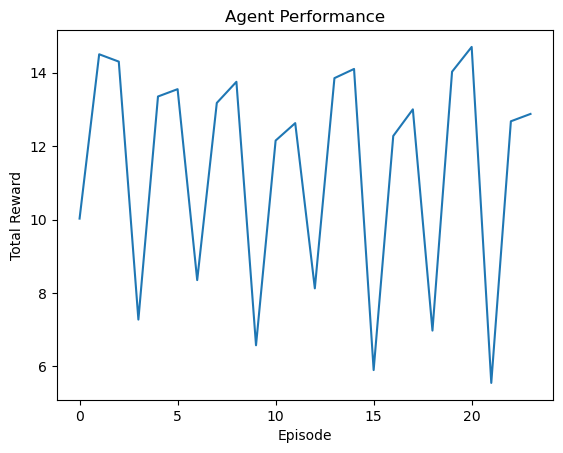

In [4]:
change_every = 600
n_resets = 8
num_episodes = change_every*n_resets

env.reset(.5,.5,theta0=theta0)
eta = .008*.125#*.5#*.3

dw_filt=0

agent.weights = np.copy(agent.weights_0*0)
n_angle=0

for episode in range(num_episodes):

    sigma_distribution = 0
    

    episode
    states = []
    actions = []
    rewards = []

    STATES = []
    PROBS = []

    env.reset_inner()
    agent.updates_filt_ = np.copy(agent.weights*0.)
    agent.updates_filt = np.copy(agent.weights*0.)

    network_reservoire_gradient.reset()
    network_reservoire.reset()

    #env.reset()
    if ((episode%change_every)==0):
        
        theta0=45*n_angle
        n_angle = n_angle+1
        
        env.reset(.5,.5,theta0=theta0)
        agent.weights = np.copy(agent.weights_0*0)
        
    done = False
    time = 0
    while (not done):
        time = time + 1
        if time > 30:
            break
            
        states = []
        actions = []
        rewards = []

        state = np.copy(env.agent_position)

        state_enc = encoder.encode_position(state).reshape(spatial_res**2,)
        logits = agent.weights@state_enc
        action_probs = np.exp(logits)/np.sum(np.exp(logits))
        action = np.random.choice(4, p=action_probs)
        states.append(state)
        actions.append(action)


        STATES.append(state)
        PROBS.append(action_probs)

        input = np.concatenate((state_enc,agent.weights.flatten()*(1-gamma_state**2) ))
        input = np.reshape(input,(np.shape(input)[0],))

        input_modulation = network_reservoire.Jin_mult@( (1-gamma_state**2) + gamma_state*agent.weights.flatten() )
        
        input_modulation= input_modulation.flatten()
        network_reservoire.step_rate(input,input_modulation,0)

        reward, done = env.step(action)

        rewards.append(reward)
        weights_old = np.copy(agent.weights) 
            

        
        for i in range(len(states)):
            
            state = states[i]
            action = actions[i]
            reward = rewards[i]

            probs = np.copy(action_probs)
            probs[action] -= 1  # Gradient of log probability
            agent.updates_filt_ = agent.updates_filt_*gamma_pg + (1.-gamma_pg)* np.outer(probs,state_enc)
            
            dw_out = np.copy(-reward*agent.learning_rate * agent.updates_filt_)*eta
            
            agent.weights += dw_out
            
        
        r_encoded = encode(reward)

        input_modulation = .1 + gamma_grad*network_reservoire_gradient.Jin_mult*reward
        input_modulation= input_modulation.flatten()

        input = np.concatenate((state_enc ,probs,r_encoded.flatten()))
        input = np.reshape(input,(np.shape(input)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        x_grad_net_coll.append(network_reservoire_gradient.S)
        y_grad_coll.append(dw_out.flatten())

        x_net_coll.append(network_reservoire.S)
        y_coll.append(logits)

    total_rewards.append(sum(rewards))

    # Update agent's policy
        
    if (episode+1) % 200 == 0:
        print(f"Episode {episode}, Total Reward: {np.mean(total_rewards[-200:])}")
        rew_to_plot.append(np.mean(total_rewards[-200:]))
        print(np.std(agent.weights))


plt.plot(rew_to_plot)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Performance')
plt.show()

In [5]:

rew_to_plot_chunked=np.reshape(np.array(rew_to_plot),(n_resets,int(change_every/200)))

Text(0, 0.5, '$\\pi_i$')

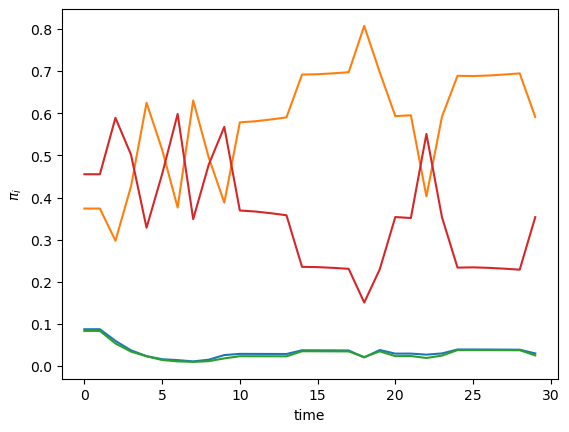

In [6]:
plt.plot(np.array(PROBS)[:,0])
plt.plot(np.array(PROBS)[:,1])
plt.plot(np.array(PROBS)[:,2])
plt.plot(np.array(PROBS)[:,3])

plt.xlabel('time')
plt.ylabel('$\pi_i$')


In [7]:
noise_size = 0.0000005
n_steps = np.shape(np.array(y_grad_coll))[1]
k_values = np.arange(n_steps)

W_out = np.linalg.pinv(x_grad_net_coll + np.random.normal(0, noise_size, size=np.shape(x_grad_net_coll))).dot(np.arctanh(np.array(y_grad_coll)[:, k_values]))

network_reservoire_gradient.Jout[:n_steps, :] = W_out.T

#plt.scatter(np.tanh(W_out.T @ np.array(x_grad_net_coll).T), np.array(y_grad_coll)[:, k_values])


In [8]:
noise_size = 0.0000005
n_steps = np.shape(np.array(y_coll))[1]

for k in range(n_steps):
    W_out = np.linalg.pinv(x_net_coll + np.random.normal(0,noise_size,size= np.shape(x_net_coll) ) ).dot((np.array(y_coll)[:,k]))

    network_reservoire.Jout[k,:] = np.copy(W_out.T)
    #plt.scatter((W_out.T@np.array(x_net_coll).T),np.array(y_coll)[:,k])


In [9]:
total_rewards = []
rew_to_plot_net_full = []

agent.weights = np.copy(agent.weights_0*0)
env.reset(.5,.5,theta0=theta0)

[ 0.4 -0.4]


In [10]:
change_every = 1200
n_resets = 16
num_episodes = change_every*n_resets

eta = .1*.02

gamma_rl = 0.9
dw_filt=0

theta0=0
sigma_distribution = 0
n_angle=0

STATES = []

r_tmp=-1

for episode in range(num_episodes):
    episode
    states = []
    actions = []
    rewards = []

    env.reset_inner()
    agent.updates_filt_ = np.copy(agent.weights*0.)
    agent.updates_filt = np.copy(agent.weights*0.)
   
    
    network_reservoire_gradient.reset()
    network_reservoire.reset()
    
    if ((episode%change_every)==0):
        theta0=45/2*n_angle
        n_angle = n_angle+1
        env.reset(.5,.5,theta0=theta0)
        agent.weights = np.copy(agent.weights_0*0)
        

    done = False
    time = 0
    states_ = []
    while (not done):
        time = time + 1
        if time > 30:
            break
            
        states = []
        actions = []
        rewards = []

        state = np.copy(env.agent_position)
        state_enc = encoder.encode_position(state).reshape(spatial_res**2,)

        weights_to_net = np.copy(agent.weights.flatten())

        input = np.concatenate((state_enc,agent.weights.flatten()*(1-gamma_state**2) ))
        input = np.reshape(input,(np.shape(input)[0],))

        input_modulation = network_reservoire.Jin_mult@( (1-gamma_state**2) + gamma_state*agent.weights.flatten() )
        input_modulation= input_modulation.flatten()
        network_reservoire.step_rate(input,input_modulation,0,if_tanh=False)
    

        logits = np.copy( network_reservoire.y)
        #logits = agent.weights@state_enc
        action_probs = np.exp(logits)/np.sum(np.exp(logits))

        action = np.random.choice(4, p=action_probs)
        states.append(state)
        actions.append(action)

        states_.append(state)

        reward, done = env.step(action)

        if done:
            state = np.copy(env.agent_position)
            states_.append(state)

        rewards.append(reward)            

        probs = np.copy(action_probs)
        probs[action] -= 1  # Gradient of log probability
            
            
        r_encoded = encode(reward)

        input_modulation = .1 + gamma_grad*network_reservoire_gradient.Jin_mult*reward#@probs
        input_modulation= input_modulation.flatten()

        input = np.concatenate((state_enc ,probs,r_encoded.flatten()))
        input = np.reshape(input,(np.shape(input)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        dw_out = np.copy(np.reshape(network_reservoire_gradient.y,(4,spatial_res**2)))
        agent.weights += dw_out

    if ((np.sum(rewards)>=r_tmp)&(np.shape(states_)[0]>0)):
        r_tmp=np.sum(rewards)
        states__ = np.copy(states_)
        
    if (((episode+1)%change_every)==0)&(episode>0):
        STATES.append(states__)
        r_tmp=-1
    total_rewards.append(sum(rewards))

    # Update agent's policy
        
    if (episode+1) % 200 == 0:
        print(f"Episode {episode}, Total Reward: {np.mean(total_rewards[-200:])}")
        rew_to_plot_net_full.append(np.mean(total_rewards[-200:]))
        print(np.std(agent.weights))


[0.5 0. ]
Episode 199, Total Reward: 5.9
0.1611598693459082
Episode 399, Total Reward: 14.25
0.28528400531624853
Episode 599, Total Reward: 14.625
0.3509191112561464
Episode 799, Total Reward: 14.725
0.4164450971257161
Episode 999, Total Reward: 14.7
0.4711976304960039
Episode 1199, Total Reward: 14.825
0.5268133709616947
[0.5 0.2]
Episode 1399, Total Reward: 1.4
0.0650539913474424
Episode 1599, Total Reward: 12.2
0.2943305125843913
Episode 1799, Total Reward: 14.625
0.4718030560074343
Episode 1999, Total Reward: 14.875
0.6693842037179109
Episode 2199, Total Reward: 14.0
0.9075555296512189
Episode 2399, Total Reward: 9.775
1.2716290394276692
[0.4 0.4]
Episode 2599, Total Reward: 3.325
0.107027592191148
Episode 2799, Total Reward: 11.95
0.26697806009077496
Episode 2999, Total Reward: 11.95
0.4710322929358116
Episode 3199, Total Reward: 12.175
0.6541090713482364
Episode 3399, Total Reward: 13.65
0.7607147795611047
Episode 3599, Total Reward: 13.85
0.8759372929028157
[0.2 0.5]
Episode 379

In [11]:
rew_to_plot_chunked

array([[10.025, 14.5  , 14.3  ],
       [ 7.275, 13.35 , 13.55 ],
       [ 8.35 , 13.175, 13.75 ],
       [ 6.575, 12.15 , 12.625],
       [ 8.125, 13.85 , 14.1  ],
       [ 5.9  , 12.275, 13.   ],
       [ 6.975, 14.025, 14.7  ],
       [ 5.55 , 12.675, 12.875]])

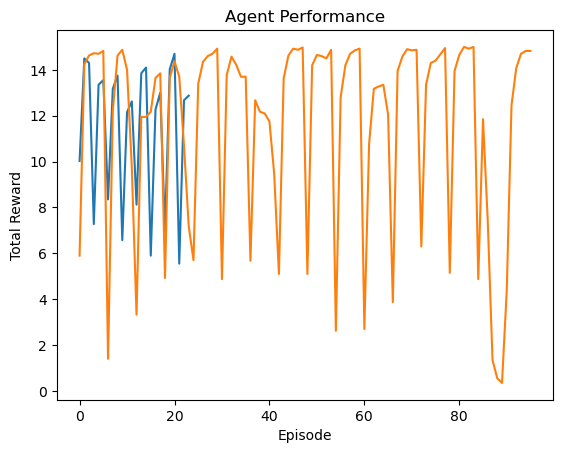

In [12]:

plt.plot(rew_to_plot)
plt.plot(rew_to_plot_net_full)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Performance')


In [13]:
rew_to_plot_net_full_chunked=np.reshape(np.array(rew_to_plot_net_full),(n_resets,int(change_every/200)))


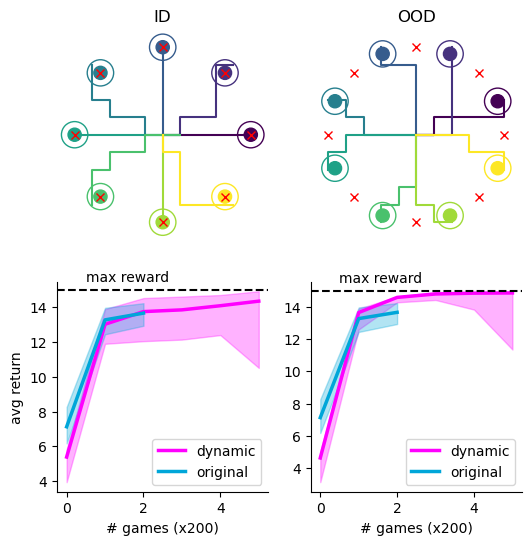

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.figure(figsize=(6,6))
light_blue = [.0,.65,.85]    



plt.subplot(221)
colors = cm.viridis(np.linspace(0, 1, 8))

radius = 0.075/2

for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2])[:,0],np.array(STATES[k*2])[:,1],color=colors[k])
    x0=0.5*np.cos((k*45 )/180*np.pi)
    y0=0.5*np.sin((k*45)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )

#plt.xlabel('x pos')
#plt.ylabel('y pos')

plt.ylim(-.6,.6)
plt.xlim(-.6,.6)

plt.title('ID')

plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(222)

plt.title('OOD')

colors = cm.viridis(np.linspace(0, 1, 8))


for k in range(int(len(STATES)/2)):
    plt.plot(np.array(STATES[k*2+1])[:,0],np.array(STATES[k*2+1])[:,1],color=colors[k])

    x0=0.5*np.cos((k*45 + 45/2)/180*np.pi)
    y0=0.5*np.sin((k*45 + 45/2)/180*np.pi)
    circle=plt.Circle((x0, y0), radius, color=colors[k], fill=True)
    plt.gca().add_patch(circle)

    circle=plt.Circle((x0, y0), radius*2, color=colors[k], fill=False)
    plt.gca().add_patch(circle)

    #plt.plot(0.5*np.cos((k*45 + 45/2)/180*np.pi), 0.5*np.sin((k*45 + 45/2)/180*np.pi),'o',color=colors[k] )

for k in range(8):
    #plt.plot(np.array(STATES[k])[:,0],np.array(STATES[k])[:,1],color=colors[k])
    plt.plot(0.5*np.cos(k*45/180*np.pi), 0.5*np.sin(k*45/180*np.pi),'xr' )
plt.ylim(-.6,.6)
plt.xlim(-.6,.6)

plt.xticks([])
plt.yticks([])
plt.axis('off')
#plt.xlabel('x pos')
#plt.ylabel('y pos')

# Subplot 3: Plots for 'ID'
plt.subplot(223)
plt.fill_between(range(len(rew_to_plot_net_full_chunked[::2, :].T)),
                 np.percentile(rew_to_plot_net_full_chunked[::2, :].T, 20, axis=1),
                 np.percentile(rew_to_plot_net_full_chunked[::2, :].T, 80, axis=1),
                 color='magenta', alpha=0.3)
plt.plot(np.median(rew_to_plot_net_full_chunked[::2, :].T, axis=1), 'magenta', linewidth=2.5, label='dynamic')

plt.fill_between(range(len(rew_to_plot_chunked.T)),
                 np.percentile(rew_to_plot_chunked.T, 20, axis=1),
                 np.percentile(rew_to_plot_chunked.T, 80, axis=1),
                 color=light_blue, alpha=0.3)
plt.plot(np.median(rew_to_plot_chunked.T, axis=1), color=light_blue, linewidth=2.5, label='original')

plt.legend()
plt.xlabel('# games (x200)')
plt.ylabel('avg return')
plt.axhline(y=15, color='black', linestyle='--')
plt.text(0.5, 15.5, 'max reward', color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Subplot 4: Plots for 'OOD'
plt.subplot(224)
plt.fill_between(range(len(rew_to_plot_net_full_chunked[1::2, :].T)),
                 np.percentile(rew_to_plot_net_full_chunked[1::2, :].T, 20, axis=1),
                 np.percentile(rew_to_plot_net_full_chunked[1::2, :].T, 80, axis=1),
                 color='magenta', alpha=0.3)
plt.plot(np.median(rew_to_plot_net_full_chunked[1::2, :].T, axis=1), 'magenta', linewidth=2.5, label='dynamic')

plt.fill_between(range(len(rew_to_plot_chunked.T)),
                 np.percentile(rew_to_plot_chunked.T, 20, axis=1),
                 np.percentile(rew_to_plot_chunked.T, 80, axis=1),
                 color=light_blue, alpha=0.3)
plt.plot(np.median(rew_to_plot_chunked.T, axis=1), color=light_blue, linewidth=2.5, label='original')

plt.axhline(y=15, color='black', linestyle='--')
plt.text(0.5, 15.5, 'max reward', color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.xlabel('# games (x200)')

plt.savefig('Fig3.png')
plt.savefig('Fig3.pdf')


plt.show()


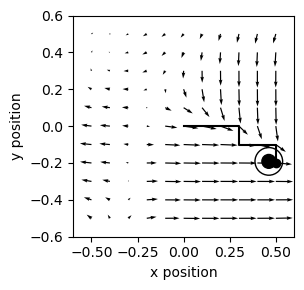

In [15]:
#plt.figure()
resolution = 11
x = np.linspace(-.5, .5, resolution)
y = np.linspace(-.5, .5, resolution)

X, Y = np.meshgrid(x, y)
VX = np.zeros_like(X)
VY = np.zeros_like(Y)

for i in range(len(X)):
    for j in range(len(Y)):
        state = np.array([X[i, j], Y[i, j]])
        state_enc = encoder.encode_position(state)
        logits = agent.weights @ state_enc  # Assuming agent and its weights are defined elsewhere
        policy=np.exp(logits)/np.sum(np.exp(logits))
        VX[i, j] = -policy[0] + policy[1]
        VY[i, j] = policy[2] - policy[3]

plt.figure(figsize=(3.5,3))

plt.quiver(X, Y, VX, VY)
plt.plot(np.array(states_)[:,0],np.array(states_)[:,1],color=[0,0,0])
plt.plot(np.array(states_)[-1,0],np.array(states_)[-1,1],'o',color=[0,0,0])


x0=0.5*np.cos((theta0)/180*np.pi)
y0=0.5*np.sin((theta0)/180*np.pi)
circle=plt.Circle((x0, y0), radius, color=[0,0,0], fill=True)
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal', adjustable='box')  

circle=plt.Circle((x0, y0), radius*2, color=[0,0,0], fill=False)

plt.ylim(-.6,.6)
plt.xlim(-.6,.6)
plt.xlabel('x position')
plt.ylabel('y position')
plt.tight_layout()  # Adjust layout

plt.gca().add_patch(circle)


plt.tight_layout()

plt.savefig('Fig3_policy.png')
plt.savefig('Fig3_policy.pdf')

plt.show()